In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
df= pd.read_csv('heart.csv')
df.head(10)
df.tail(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
908,63,M,ASY,140,187,0,LVH,144,Y,4.0,Up,1
909,63,F,ASY,124,197,0,Normal,136,Y,0.0,Flat,1
910,41,M,ATA,120,157,0,Normal,182,N,0.0,Up,0
911,59,M,ASY,164,176,1,LVH,90,N,1.0,Flat,1
912,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
917,38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


## Checking Unique Features in Qualitative Data
Before we proceed to feature engineering, we need to see what kind of categorical data that we have. Thus, checking unique features is necessary

In [4]:
for column_names in df.columns:
    if df[column_names].dtypes==object:
        print(column_names+' has ')
        print(df[column_names].unique())

Sex has 
['M' 'F']
ChestPainType has 
['ATA' 'NAP' 'ASY' 'TA']
RestingECG has 
['Normal' 'ST' 'LVH']
ExerciseAngina has 
['N' 'Y']
ST_Slope has 
['Up' 'Flat' 'Down']


## Checking Quantitative Data
It is the same as previous, we need to see the statistical data to determine the null values or outliers

In [5]:
for column_names in df.columns:
    if df[column_names].dtypes!=object:
        print(column_names+' has ')
        print(df[column_names].describe())

Age has 
count    918.000000
mean      53.510893
std        9.432617
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: Age, dtype: float64
RestingBP has 
count    918.000000
mean     132.396514
std       18.514154
min        0.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: RestingBP, dtype: float64
Cholesterol has 
count    918.000000
mean     198.799564
std      109.384145
min        0.000000
25%      173.250000
50%      223.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64
FastingBS has 
count    918.000000
mean       0.233115
std        0.423046
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: FastingBS, dtype: float64
MaxHR has 
count    918.000000
mean     136.809368
std       25.460334
min       60.000000
25%      120.000000
50%      138.000000
75%      156.000000
max      202.000000
Name: Max

In [6]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [7]:
for column_names in df.columns:
    if df[column_names].max()!=1 and (df[column_names].dtypes=='float64' or df[column_names].dtypes=='int64'):
        print(column_names)

Age
RestingBP
Cholesterol
MaxHR
Oldpeak


## Data Visualization

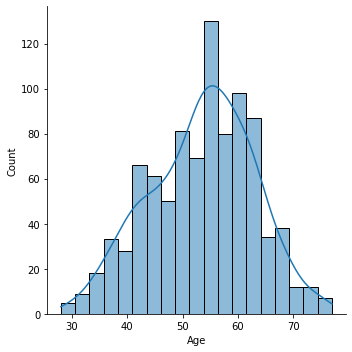

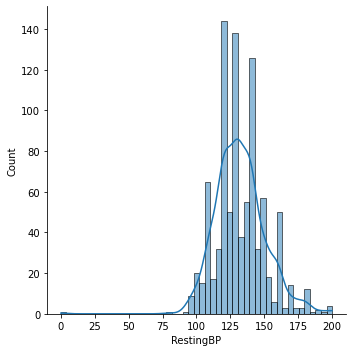

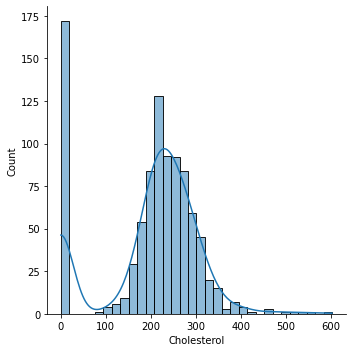

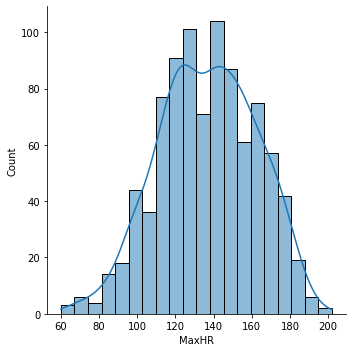

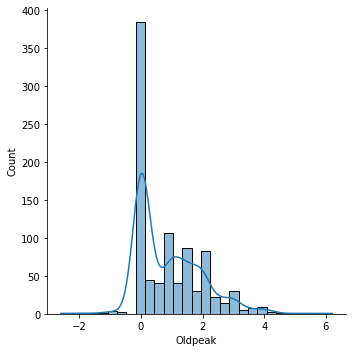

In [8]:
for column_names in df.columns:
    if df[column_names].max()!=1 and (df[column_names].dtypes=='float64' or df[column_names].dtypes=='int64'):
        sns.displot(x=df[column_names], kde=True)

<AxesSubplot:xlabel='Age'>

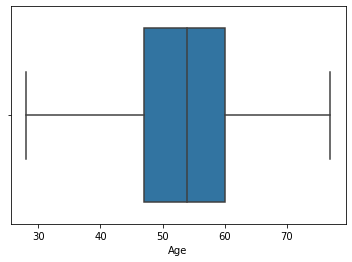

In [9]:
sns.boxplot(x=df['Age'])

<AxesSubplot:xlabel='RestingBP'>

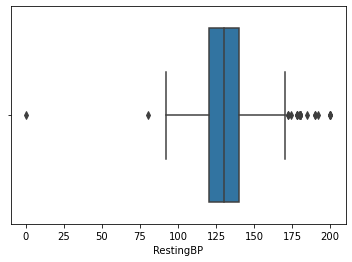

In [10]:
sns.boxplot(x=df['RestingBP'])

<AxesSubplot:xlabel='Cholesterol'>

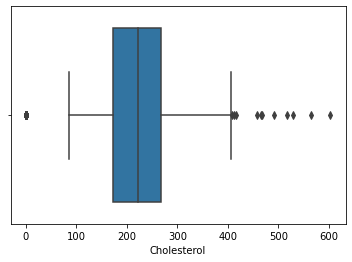

In [11]:
sns.boxplot(x=df['Cholesterol'])

<AxesSubplot:xlabel='MaxHR'>

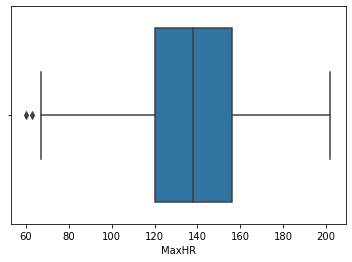

In [12]:
sns.boxplot(x=df['MaxHR'])

<AxesSubplot:xlabel='Oldpeak'>

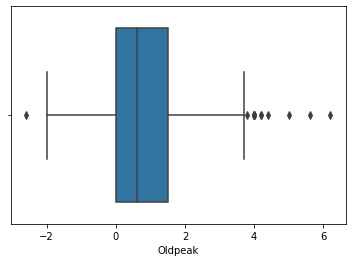

In [13]:
sns.boxplot(x=df['Oldpeak'])

## Feature Engineering
Since we need to consider the outliers would affect the model or not, we need to see how much the outliers are in certain categories. Then, we need to consider replacing it

In [14]:
Q1=df.quantile(0.25)
Q3=df.quantile(0.75)
IQR=Q3-Q1
numerical_value=['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
((df[numerical_value] < (Q1 - 1.5 * IQR)) | (df[numerical_value] > (Q3 + 1.5 * IQR))).sum()

Age               0
Cholesterol     183
FastingBS         0
HeartDisease      0
MaxHR             2
Oldpeak          16
RestingBP        28
dtype: int64

In [15]:
print(df[numerical_value].skew())

Age           -0.195933
RestingBP      0.179839
Cholesterol   -0.610086
MaxHR         -0.144359
Oldpeak        1.022872
dtype: float64


In [16]:
print(df['Oldpeak'].quantile(0.1))
print(df['Oldpeak'].quantile(0.9))

0.0
2.3


In [17]:
Q1= df.quantile(0.1)
Q3=df.quantile(0.9)
IQR=Q3-Q1
df["Oldpeak"] = np.where(df["Oldpeak"] <0.0, 0.0,df['Oldpeak'])
df["Oldpeak"] = np.where(df["Oldpeak"] >2.3, 2.3,df['Oldpeak'])
print(df['Oldpeak'].skew())

0.48051852644361337


In [18]:
label=LabelEncoder()
category_data=['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
for word in category_data:
    df[word]=label.fit_transform(df[word])

In [19]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [20]:
df.describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,0.781046,132.396514,198.799564,0.233115,0.989107,136.809368,0.404139,0.819390,1.361656,0.553377
std,9.432617,0.407701,0.956519,18.514154,109.384145,0.423046,0.631671,25.460334,0.490992,0.861154,0.607056,0.497414
min,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,1.000000,0.000000,120.000000,173.250000,0.000000,1.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,0.000000,130.000000,223.000000,0.000000,1.000000,138.000000,0.000000,0.600000,1.000000,1.000000
75%,60.000000,1.000000,2.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,2.300000,2.000000,1.000000


In [21]:
scaled=MinMaxScaler()
need_to_scaled=['Age','ChestPainType','RestingBP','Cholesterol','RestingECG','MaxHR','Oldpeak','ST_Slope']

df[need_to_scaled]=scaled.fit_transform(df[need_to_scaled])

## Splitting Data Test and Train

In [22]:
x=df.drop(columns='HeartDisease')
y=df['HeartDisease']

In [23]:
x_train,x_test,y_train,y_test=train_test_split(x,y, random_state=123,test_size=0.3)

In [24]:
y_train

132    1
9      0
254    1
787    1
82     1
      ..
98     0
322    1
382    1
365    1
510    0
Name: HeartDisease, Length: 642, dtype: int64

## Machine Learning

In [25]:
lsvc= LinearSVC()
lsvc.fit(x_train,y_train)
score = lsvc.score(x_train, y_train)
print("Score: ", score)

Score:  0.8644859813084113


In [26]:
y_pred = lsvc.predict(x_test)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       120
           1       0.84      0.88      0.86       156

    accuracy                           0.84       276
   macro avg       0.84      0.83      0.84       276
weighted avg       0.84      0.84      0.84       276

